In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D
from keras import layers
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.applications as kapps
from keras import backend as k
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import callbacks

In [2]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

current_path = os.getcwd() 
images_path = current_path + r'/images2/image_train/'
images_list = os.listdir(images_path)
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:8400,:]
y_val = y_train.iloc[:8400,:]
X_train = X_train.iloc[:84000,:]
y_train = y_train.iloc[:84000:,:]
X_test = X_test.iloc[:13800,:]
y_test = y_test.iloc[:13800,:]

X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

batch_size = 32 #
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)


Found 61138 validated image filenames belonging to 27 classes.
Found 8400 validated image filenames belonging to 27 classes.
Found 13800 validated image filenames belonging to 27 classes.


In [3]:
basemodel = kapps.xception.Xception( input_shape = (240, 240, 3) ,include_top = False, weights = 'imagenet')
basemodel.trainable = False

x = GlobalAveragePooling2D() (basemodel.output) #
x = layers.Flatten() (x)
x = layers.Dense(1024, activation='relu') (x)
x = layers.BatchNormalization (trainable = True) (x) #
x = layers.Dropout(0.35) (x)
x = layers.Dense(512, activation='relu') (x)
x = layers.BatchNormalization (trainable = True) (x)
x = layers.Dropout(0.30) (x)
x = layers.Dense(256, activation='relu') (x)
x = layers.BatchNormalization (trainable = True) (x)
x = layers.Dropout(0.25) (x)
x = layers.Dense(128, activation='relu') (x)
x = layers.BatchNormalization (trainable = True) (x)
x = layers.Dense(27, activation='softmax') (x)

model = tf.keras.models.Model(basemodel.input, x)
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [4]:
cwd = os.getcwd()
filepath = cwd
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, save_weights_only = False,
                                       mode = 'min', save_freq = 'epoch')
epoch = 10

test_history = model.fit(train_generator, epochs = epoch,steps_per_epoch = len(X_train)//batch_size, validation_data = val_generator,
                        validation_steps = len(X_val)//batch_size) #, callbacks = [checkpoint])

Epoch 1/10
1910/1910 [==============================] - 2531s 1s/step - loss: 2.3138 - acc: 0.3299 - val_loss: 2.1094 - val_acc: 0.3805
Epoch 2/10
1910/1910 [==============================] - 2631s 1s/step - loss: 2.0934 - acc: 0.3833 - val_loss: 2.0396 - val_acc: 0.3987
Epoch 3/10
1910/1910 [==============================] - 2650s 1s/step - loss: 2.0278 - acc: 0.4015 - val_loss: 1.9881 - val_acc: 0.4102
Epoch 4/10
1910/1910 [==============================] - 2627s 1s/step - loss: 1.9880 - acc: 0.4100 - val_loss: 1.9233 - val_acc: 0.4265
Epoch 5/10
1910/1910 [==============================] - 2573s 1s/step - loss: 1.9487 - acc: 0.4214 - val_loss: 1.9020 - val_acc: 0.4352
Epoch 6/10
1910/1910 [==============================] - 2625s 1s/step - loss: 1.9214 - acc: 0.4321 - val_loss: 1.8752 - val_acc: 0.4370
Epoch 7/10
1910/1910 [==============================] - 2695s 1s/step - loss: 1.8992 - acc: 0.4376 - val_loss: 1.8645 - val_acc: 0.4463
Epoch 8/10
1910/1910 [==========================

In [5]:
for layer in basemodel.layers[-4:]:
    layer.trainable = True
    
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=2, mode='min')
model.compile(optimizer= Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze21 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(X_train)//batch_size, validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size, callbacks = [lr_plateau])

Epoch 1/10
1910/1910 [==============================] - 2946s 2s/step - loss: 1.8513 - accuracy: 0.4501 - val_loss: 1.4540 - val_accuracy: 0.5513
Epoch 2/10
1910/1910 [==============================] - 3005s 2s/step - loss: 1.8036 - accuracy: 0.4617 - val_loss: 1.4014 - val_accuracy: 0.5745
Epoch 3/10
1910/1910 [==============================] - 2967s 2s/step - loss: 1.7685 - accuracy: 0.4735 - val_loss: 1.3891 - val_accuracy: 0.5768
Epoch 4/10
1910/1910 [==============================] - 3000s 2s/step - loss: 1.7361 - accuracy: 0.4816 - val_loss: 1.4000 - val_accuracy: 0.5736

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/10
1910/1910 [==============================] - 3068s 2s/step - loss: 1.6558 - accuracy: 0.5035 - val_loss: 1.3302 - val_accuracy: 0.5959
Epoch 6/10
1910/1910 [==============================] - 3067s 2s/step - loss: 1.6247 - accuracy: 0.5136 - val_loss: 1.3160 - val_accuracy: 0.6034
Epoch 7/10
1910/1910 [=====================

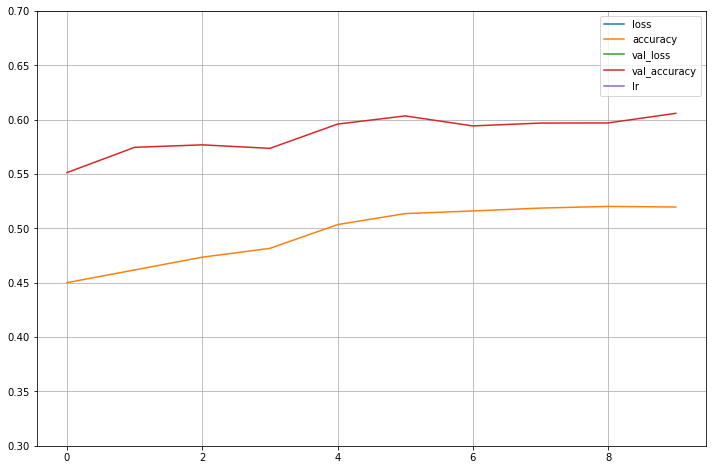

In [8]:
import pandas as pd
pd.DataFrame(hist_unfreeze21.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.7) 
plt.show()

y_pred21 = model.predict(test_generator, verbose = 1)
y_pred21 = y_pred19.argmax(axis = 1)